## Import Packages

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Data Reading and Preprocessing

In [2]:
# Reading generated power (Solar and wind) data
# Dataset link : https://data.open-power-system-data.org/time_series/2020-10-06

data_path = r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-time_series-2020-10-06\time_series_60min_singleindex.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/time_series_60min_singleindex.csv"

df = pd.read_csv(data_path,
                 usecols=(lambda s: s.startswith('utc') | s.startswith('DE')),
                 parse_dates=[0], index_col=0)

In [3]:
# As we see in the last two graphs , The wind and solar power aer seasonal  

production_wind_solar = df[['DE_wind_generation_actual', 'DE_solar_generation_actual']]
production_wind_solar.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2014-12-31 23:00:00+00:00,NaN,NaN
2015-01-01 00:00:00+00:00,8852.0,NaN
2015-01-01 01:00:00+00:00,9054.0,NaN
2015-01-01 02:00:00+00:00,9070.0,NaN
2015-01-01 03:00:00+00:00,9163.0,NaN


In [4]:
# Reading weather data to be combined with power data  
# https://data.open-power-system-data.org/weather_data/2020-09-16
# Metadata link : https://data.open-power-system-data.org/weather_data/2020-09-16/README.md


data_path = r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-weather_data-2020-09-16\weather_data.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/weather_data.csv"

weather = pd.read_csv(data_path, parse_dates=[0], index_col=0)
weather.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [5]:
# resampling weather data by day to make it ready to be combined with power data  

weather_by_day = weather.groupby(weather.index).mean()
weather_by_day.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [6]:
# Meging (Solar & wind) data with (weather) data

combined = pd.merge(production_wind_solar, weather_by_day, how='left', left_index=True, right_index=True)
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,-6.495,0.0,0.0,0.100,0.0,0.0,-13.029,0.0,...,0.0,0.610,0.0,0.0,-11.515,0.0,0.0,-8.337,0.0,0.0
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0


In [7]:
# Note | we have the solar and wind data from 01/01/2015 to 30/09/2020
#                   and temperature data from 01/01/1980 to 31/12/2019
#                   we should get the intersection between them to be able to create a powerful model
#                   The intersection between them is from 
#                                             01/01/2015 to 31/12/2019

combined = combined.loc[combined.index >= '2015-01-01 00:00:00+00:00', :]
combined = combined.loc[combined.index <= '2019-12-31 23:00:00+00:00', :]

combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,NaN,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


In [8]:
# There are some nulls found should be filled by the mean of the same column

combined["DE_wind_generation_actual" ].fillna(combined["DE_wind_generation_actual" ].mean(), inplace=True)
combined["DE_solar_generation_actual"].fillna(combined["DE_solar_generation_actual"].mean(), inplace=True)

combined.isnull().sum()

DE_wind_generation_actual          0
DE_solar_generation_actual         0
AT_temperature                     0
AT_radiation_direct_horizontal     0
AT_radiation_diffuse_horizontal    0
                                  ..
SI_radiation_direct_horizontal     0
SI_radiation_diffuse_horizontal    0
SK_temperature                     0
SK_radiation_direct_horizontal     0
SK_radiation_diffuse_horizontal    0
Length: 86, dtype: int64

In [9]:
# It is clear that the data should be scaled to make sure that the model will give an accurate result

X_scaler = MinMaxScaler().fit(combined.iloc[:,2:])
X_scaled = X_scaler.transform(combined.iloc[:,2:])

y_scaler = MinMaxScaler().fit(combined.iloc[:,:2])
y_scaled = y_scaler.transform(combined.iloc[:,:2])

In [10]:
# Splitting data into train & test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [11]:
# Reahping the data to be suitable for forcasting 

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test  = X_test .reshape(X_test .shape[0], 1, X_test .shape[1])

X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

## NBeats

In [12]:
from Energy_Models.NBEATS import NBeatsNet

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = NBeatsNet(1,84,2)

In [13]:
model.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 1, 84)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['input_variable[0][0]']         
                                                                                           

 lambda_39 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_40 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_41 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_42 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_43 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_44

                                                                                                  
 lambda_81 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_82 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 lambda_83 (Lambda)             (None, 1)            0           ['input_variable[0][0]']         
                                                                                                  
 0/0/trend/d1 (Dense)           (None, 256)          512         ['lambda[0][0]',                 
                                                                  'lambda_1[0][0]',               
                                                                  'lambda_2[0][0]',               
          

                                                                  'lambda_76[0][0]',              
                                                                  'lambda_77[0][0]',              
                                                                  'lambda_78[0][0]',              
                                                                  'lambda_79[0][0]',              
                                                                  'lambda_80[0][0]',              
                                                                  'lambda_81[0][0]',              
                                                                  'lambda_82[0][0]',              
                                                                  'lambda_83[0][0]']              
                                                                                                  
 0/0/trend/d2 (Dense)           (None, 256)          65792       ['0/0/trend/d1[0][0]',           
          

                                                                  '0/0/trend/d1[74][0]',          
                                                                  '0/0/trend/d1[75][0]',          
                                                                  '0/0/trend/d1[76][0]',          
                                                                  '0/0/trend/d1[77][0]',          
                                                                  '0/0/trend/d1[78][0]',          
                                                                  '0/0/trend/d1[79][0]',          
                                                                  '0/0/trend/d1[80][0]',          
                                                                  '0/0/trend/d1[81][0]',          
                                                                  '0/0/trend/d1[82][0]',          
                                                                  '0/0/trend/d1[83][0]']          
          

                                                                  '0/0/trend/d2[72][0]',          
                                                                  '0/0/trend/d2[73][0]',          
                                                                  '0/0/trend/d2[74][0]',          
                                                                  '0/0/trend/d2[75][0]',          
                                                                  '0/0/trend/d2[76][0]',          
                                                                  '0/0/trend/d2[77][0]',          
                                                                  '0/0/trend/d2[78][0]',          
                                                                  '0/0/trend/d2[79][0]',          
                                                                  '0/0/trend/d2[80][0]',          
                                                                  '0/0/trend/d2[81][0]',          
          

                                                                  '0/0/trend/d3[70][0]',          
                                                                  '0/0/trend/d3[71][0]',          
                                                                  '0/0/trend/d3[72][0]',          
                                                                  '0/0/trend/d3[73][0]',          
                                                                  '0/0/trend/d3[74][0]',          
                                                                  '0/0/trend/d3[75][0]',          
                                                                  '0/0/trend/d3[76][0]',          
                                                                  '0/0/trend/d3[77][0]',          
                                                                  '0/0/trend/d3[78][0]',          
                                                                  '0/0/trend/d3[79][0]',          
          

                                                                  '0/0/trend/d4[34][0]',          
                                                                  '0/0/trend/d4[34][0]',          
                                                                  '0/0/trend/d4[35][0]',          
                                                                  '0/0/trend/d4[35][0]',          
                                                                  '0/0/trend/d4[36][0]',          
                                                                  '0/0/trend/d4[36][0]',          
                                                                  '0/0/trend/d4[37][0]',          
                                                                  '0/0/trend/d4[37][0]',          
                                                                  '0/0/trend/d4[38][0]',          
                                                                  '0/0/trend/d4[38][0]',          
          

                                                                  '0/0/trend/d4[75][0]',          
                                                                  '0/0/trend/d4[76][0]',          
                                                                  '0/0/trend/d4[76][0]',          
                                                                  '0/0/trend/d4[77][0]',          
                                                                  '0/0/trend/d4[77][0]',          
                                                                  '0/0/trend/d4[78][0]',          
                                                                  '0/0/trend/d4[78][0]',          
                                                                  '0/0/trend/d4[79][0]',          
                                                                  '0/0/trend/d4[79][0]',          
                                                                  '0/0/trend/d4[80][0]',          
          

                                                                  '0/0/trend/theta_f_b[131][0]',  
                                                                  '0/0/trend/theta_f_b[133][0]',  
                                                                  '0/0/trend/theta_f_b[135][0]',  
                                                                  '0/0/trend/theta_f_b[137][0]',  
                                                                  '0/0/trend/theta_f_b[139][0]',  
                                                                  '0/0/trend/theta_f_b[141][0]',  
                                                                  '0/0/trend/theta_f_b[143][0]',  
                                                                  '0/0/trend/theta_f_b[145][0]',  
                                                                  '0/0/trend/theta_f_b[147][0]',  
                                                                  '0/0/trend/theta_f_b[149][0]',  
          

 subtract_21 (Subtract)         (None, 1)            0           ['lambda_21[0][0]',              
                                                                  'lambda_84[21][0]']             
                                                                                                  
 subtract_22 (Subtract)         (None, 1)            0           ['lambda_22[0][0]',              
                                                                  'lambda_84[22][0]']             
                                                                                                  
 subtract_23 (Subtract)         (None, 1)            0           ['lambda_23[0][0]',              
                                                                  'lambda_84[23][0]']             
                                                                                                  
 subtract_24 (Subtract)         (None, 1)            0           ['lambda_24[0][0]',              
          

                                                                                                  
 subtract_49 (Subtract)         (None, 1)            0           ['lambda_49[0][0]',              
                                                                  'lambda_84[49][0]']             
                                                                                                  
 subtract_50 (Subtract)         (None, 1)            0           ['lambda_50[0][0]',              
                                                                  'lambda_84[50][0]']             
                                                                                                  
 subtract_51 (Subtract)         (None, 1)            0           ['lambda_51[0][0]',              
                                                                  'lambda_84[51][0]']             
                                                                                                  
 subtract_

                                                                  'lambda_84[76][0]']             
                                                                                                  
 subtract_77 (Subtract)         (None, 1)            0           ['lambda_77[0][0]',              
                                                                  'lambda_84[77][0]']             
                                                                                                  
 subtract_78 (Subtract)         (None, 1)            0           ['lambda_78[0][0]',              
                                                                  'lambda_84[78][0]']             
                                                                                                  
 subtract_79 (Subtract)         (None, 1)            0           ['lambda_79[0][0]',              
                                                                  'lambda_84[79][0]']             
          

                                                                  'subtract_60[0][0]',            
                                                                  'subtract_61[0][0]',            
                                                                  'subtract_62[0][0]',            
                                                                  'subtract_63[0][0]',            
                                                                  'subtract_64[0][0]',            
                                                                  'subtract_65[0][0]',            
                                                                  'subtract_66[0][0]',            
                                                                  'subtract_67[0][0]',            
                                                                  'subtract_68[0][0]',            
                                                                  'subtract_69[0][0]',            
          

                                                                  '0/1/trend/d1[58][0]',          
                                                                  '0/1/trend/d1[59][0]',          
                                                                  '0/1/trend/d1[60][0]',          
                                                                  '0/1/trend/d1[61][0]',          
                                                                  '0/1/trend/d1[62][0]',          
                                                                  '0/1/trend/d1[63][0]',          
                                                                  '0/1/trend/d1[64][0]',          
                                                                  '0/1/trend/d1[65][0]',          
                                                                  '0/1/trend/d1[66][0]',          
                                                                  '0/1/trend/d1[67][0]',          
          

                                                                  '0/1/trend/d2[56][0]',          
                                                                  '0/1/trend/d2[57][0]',          
                                                                  '0/1/trend/d2[58][0]',          
                                                                  '0/1/trend/d2[59][0]',          
                                                                  '0/1/trend/d2[60][0]',          
                                                                  '0/1/trend/d2[61][0]',          
                                                                  '0/1/trend/d2[62][0]',          
                                                                  '0/1/trend/d2[63][0]',          
                                                                  '0/1/trend/d2[64][0]',          
                                                                  '0/1/trend/d2[65][0]',          
          

                                                                  '0/1/trend/d3[54][0]',          
                                                                  '0/1/trend/d3[55][0]',          
                                                                  '0/1/trend/d3[56][0]',          
                                                                  '0/1/trend/d3[57][0]',          
                                                                  '0/1/trend/d3[58][0]',          
                                                                  '0/1/trend/d3[59][0]',          
                                                                  '0/1/trend/d3[60][0]',          
                                                                  '0/1/trend/d3[61][0]',          
                                                                  '0/1/trend/d3[62][0]',          
                                                                  '0/1/trend/d3[63][0]',          
          

                                                                  '0/1/trend/d4[26][0]',          
                                                                  '0/1/trend/d4[26][0]',          
                                                                  '0/1/trend/d4[27][0]',          
                                                                  '0/1/trend/d4[27][0]',          
                                                                  '0/1/trend/d4[28][0]',          
                                                                  '0/1/trend/d4[28][0]',          
                                                                  '0/1/trend/d4[29][0]',          
                                                                  '0/1/trend/d4[29][0]',          
                                                                  '0/1/trend/d4[30][0]',          
                                                                  '0/1/trend/d4[30][0]',          
          

                                                                  '0/1/trend/d4[67][0]',          
                                                                  '0/1/trend/d4[68][0]',          
                                                                  '0/1/trend/d4[68][0]',          
                                                                  '0/1/trend/d4[69][0]',          
                                                                  '0/1/trend/d4[69][0]',          
                                                                  '0/1/trend/d4[70][0]',          
                                                                  '0/1/trend/d4[70][0]',          
                                                                  '0/1/trend/d4[71][0]',          
                                                                  '0/1/trend/d4[71][0]',          
                                                                  '0/1/trend/d4[72][0]',          
          

                                                                  '0/1/trend/theta_f_b[99][0]',   
                                                                  '0/1/trend/theta_f_b[101][0]',  
                                                                  '0/1/trend/theta_f_b[103][0]',  
                                                                  '0/1/trend/theta_f_b[105][0]',  
                                                                  '0/1/trend/theta_f_b[107][0]',  
                                                                  '0/1/trend/theta_f_b[109][0]',  
                                                                  '0/1/trend/theta_f_b[111][0]',  
                                                                  '0/1/trend/theta_f_b[113][0]',  
                                                                  '0/1/trend/theta_f_b[115][0]',  
                                                                  '0/1/trend/theta_f_b[117][0]',  
          

                                                                                                  
 subtract_100 (Subtract)        (None, 1)            0           ['subtract_16[0][0]',            
                                                                  'lambda_86[16][0]']             
                                                                                                  
 subtract_101 (Subtract)        (None, 1)            0           ['subtract_17[0][0]',            
                                                                  'lambda_86[17][0]']             
                                                                                                  
 subtract_102 (Subtract)        (None, 1)            0           ['subtract_18[0][0]',            
                                                                  'lambda_86[18][0]']             
                                                                                                  
 subtract_

                                                                  'lambda_86[43][0]']             
                                                                                                  
 subtract_128 (Subtract)        (None, 1)            0           ['subtract_44[0][0]',            
                                                                  'lambda_86[44][0]']             
                                                                                                  
 subtract_129 (Subtract)        (None, 1)            0           ['subtract_45[0][0]',            
                                                                  'lambda_86[45][0]']             
                                                                                                  
 subtract_130 (Subtract)        (None, 1)            0           ['subtract_46[0][0]',            
                                                                  'lambda_86[46][0]']             
          

 subtract_155 (Subtract)        (None, 1)            0           ['subtract_71[0][0]',            
                                                                  'lambda_86[71][0]']             
                                                                                                  
 subtract_156 (Subtract)        (None, 1)            0           ['subtract_72[0][0]',            
                                                                  'lambda_86[72][0]']             
                                                                                                  
 subtract_157 (Subtract)        (None, 1)            0           ['subtract_73[0][0]',            
                                                                  'lambda_86[73][0]']             
                                                                                                  
 subtract_158 (Subtract)        (None, 1)            0           ['subtract_74[0][0]',            
          

                                                                  'subtract_128[0][0]',           
                                                                  'subtract_129[0][0]',           
                                                                  'subtract_130[0][0]',           
                                                                  'subtract_131[0][0]',           
                                                                  'subtract_132[0][0]',           
                                                                  'subtract_133[0][0]',           
                                                                  'subtract_134[0][0]',           
                                                                  'subtract_135[0][0]',           
                                                                  'subtract_136[0][0]',           
                                                                  'subtract_137[0][0]',           
          

                                                                  '0/2/trend/d1[42][0]',          
                                                                  '0/2/trend/d1[43][0]',          
                                                                  '0/2/trend/d1[44][0]',          
                                                                  '0/2/trend/d1[45][0]',          
                                                                  '0/2/trend/d1[46][0]',          
                                                                  '0/2/trend/d1[47][0]',          
                                                                  '0/2/trend/d1[48][0]',          
                                                                  '0/2/trend/d1[49][0]',          
                                                                  '0/2/trend/d1[50][0]',          
                                                                  '0/2/trend/d1[51][0]',          
          

                                                                  '0/2/trend/d2[40][0]',          
                                                                  '0/2/trend/d2[41][0]',          
                                                                  '0/2/trend/d2[42][0]',          
                                                                  '0/2/trend/d2[43][0]',          
                                                                  '0/2/trend/d2[44][0]',          
                                                                  '0/2/trend/d2[45][0]',          
                                                                  '0/2/trend/d2[46][0]',          
                                                                  '0/2/trend/d2[47][0]',          
                                                                  '0/2/trend/d2[48][0]',          
                                                                  '0/2/trend/d2[49][0]',          
          

                                                                  '0/2/trend/d3[38][0]',          
                                                                  '0/2/trend/d3[39][0]',          
                                                                  '0/2/trend/d3[40][0]',          
                                                                  '0/2/trend/d3[41][0]',          
                                                                  '0/2/trend/d3[42][0]',          
                                                                  '0/2/trend/d3[43][0]',          
                                                                  '0/2/trend/d3[44][0]',          
                                                                  '0/2/trend/d3[45][0]',          
                                                                  '0/2/trend/d3[46][0]',          
                                                                  '0/2/trend/d3[47][0]',          
          

                                                                  '0/2/trend/d4[18][0]',          
                                                                  '0/2/trend/d4[18][0]',          
                                                                  '0/2/trend/d4[19][0]',          
                                                                  '0/2/trend/d4[19][0]',          
                                                                  '0/2/trend/d4[20][0]',          
                                                                  '0/2/trend/d4[20][0]',          
                                                                  '0/2/trend/d4[21][0]',          
                                                                  '0/2/trend/d4[21][0]',          
                                                                  '0/2/trend/d4[22][0]',          
                                                                  '0/2/trend/d4[22][0]',          
          

                                                                  '0/2/trend/d4[59][0]',          
                                                                  '0/2/trend/d4[60][0]',          
                                                                  '0/2/trend/d4[60][0]',          
                                                                  '0/2/trend/d4[61][0]',          
                                                                  '0/2/trend/d4[61][0]',          
                                                                  '0/2/trend/d4[62][0]',          
                                                                  '0/2/trend/d4[62][0]',          
                                                                  '0/2/trend/d4[63][0]',          
                                                                  '0/2/trend/d4[63][0]',          
                                                                  '0/2/trend/d4[64][0]',          
          

                                                                  '0/2/trend/theta_f_b[67][0]',   
                                                                  '0/2/trend/theta_f_b[69][0]',   
                                                                  '0/2/trend/theta_f_b[71][0]',   
                                                                  '0/2/trend/theta_f_b[73][0]',   
                                                                  '0/2/trend/theta_f_b[75][0]',   
                                                                  '0/2/trend/theta_f_b[77][0]',   
                                                                  '0/2/trend/theta_f_b[79][0]',   
                                                                  '0/2/trend/theta_f_b[81][0]',   
                                                                  '0/2/trend/theta_f_b[83][0]',   
                                                                  '0/2/trend/theta_f_b[85][0]',   
          

                                                                  'lambda_88[10][0]']             
                                                                                                  
 subtract_179 (Subtract)        (None, 1)            0           ['subtract_95[0][0]',            
                                                                  'lambda_88[11][0]']             
                                                                                                  
 subtract_180 (Subtract)        (None, 1)            0           ['subtract_96[0][0]',            
                                                                  'lambda_88[12][0]']             
                                                                                                  
 subtract_181 (Subtract)        (None, 1)            0           ['subtract_97[0][0]',            
                                                                  'lambda_88[13][0]']             
          

 subtract_206 (Subtract)        (None, 1)            0           ['subtract_122[0][0]',           
                                                                  'lambda_88[38][0]']             
                                                                                                  
 subtract_207 (Subtract)        (None, 1)            0           ['subtract_123[0][0]',           
                                                                  'lambda_88[39][0]']             
                                                                                                  
 subtract_208 (Subtract)        (None, 1)            0           ['subtract_124[0][0]',           
                                                                  'lambda_88[40][0]']             
                                                                                                  
 subtract_209 (Subtract)        (None, 1)            0           ['subtract_125[0][0]',           
          

                                                                                                  
 subtract_234 (Subtract)        (None, 1)            0           ['subtract_150[0][0]',           
                                                                  'lambda_88[66][0]']             
                                                                                                  
 subtract_235 (Subtract)        (None, 1)            0           ['subtract_151[0][0]',           
                                                                  'lambda_88[67][0]']             
                                                                                                  
 subtract_236 (Subtract)        (None, 1)            0           ['subtract_152[0][0]',           
                                                                  'lambda_88[68][0]']             
                                                                                                  
 subtract_

                                                                  'subtract_196[0][0]',           
                                                                  'subtract_197[0][0]',           
                                                                  'subtract_198[0][0]',           
                                                                  'subtract_199[0][0]',           
                                                                  'subtract_200[0][0]',           
                                                                  'subtract_201[0][0]',           
                                                                  'subtract_202[0][0]',           
                                                                  'subtract_203[0][0]',           
                                                                  'subtract_204[0][0]',           
                                                                  'subtract_205[0][0]',           
          

                                                                  '1/0/seasonality/d1[26][0]',    
                                                                  '1/0/seasonality/d1[27][0]',    
                                                                  '1/0/seasonality/d1[28][0]',    
                                                                  '1/0/seasonality/d1[29][0]',    
                                                                  '1/0/seasonality/d1[30][0]',    
                                                                  '1/0/seasonality/d1[31][0]',    
                                                                  '1/0/seasonality/d1[32][0]',    
                                                                  '1/0/seasonality/d1[33][0]',    
                                                                  '1/0/seasonality/d1[34][0]',    
                                                                  '1/0/seasonality/d1[35][0]',    
          

                                                                  '1/0/seasonality/d2[24][0]',    
                                                                  '1/0/seasonality/d2[25][0]',    
                                                                  '1/0/seasonality/d2[26][0]',    
                                                                  '1/0/seasonality/d2[27][0]',    
                                                                  '1/0/seasonality/d2[28][0]',    
                                                                  '1/0/seasonality/d2[29][0]',    
                                                                  '1/0/seasonality/d2[30][0]',    
                                                                  '1/0/seasonality/d2[31][0]',    
                                                                  '1/0/seasonality/d2[32][0]',    
                                                                  '1/0/seasonality/d2[33][0]',    
          

                                                                  '1/0/seasonality/d3[22][0]',    
                                                                  '1/0/seasonality/d3[23][0]',    
                                                                  '1/0/seasonality/d3[24][0]',    
                                                                  '1/0/seasonality/d3[25][0]',    
                                                                  '1/0/seasonality/d3[26][0]',    
                                                                  '1/0/seasonality/d3[27][0]',    
                                                                  '1/0/seasonality/d3[28][0]',    
                                                                  '1/0/seasonality/d3[29][0]',    
                                                                  '1/0/seasonality/d3[30][0]',    
                                                                  '1/0/seasonality/d3[31][0]',    
          

                                                                  '1/0/seasonality/d4[20][0]',    
                                                                  '1/0/seasonality/d4[21][0]',    
                                                                  '1/0/seasonality/d4[22][0]',    
                                                                  '1/0/seasonality/d4[23][0]',    
                                                                  '1/0/seasonality/d4[24][0]',    
                                                                  '1/0/seasonality/d4[25][0]',    
                                                                  '1/0/seasonality/d4[26][0]',    
                                                                  '1/0/seasonality/d4[27][0]',    
                                                                  '1/0/seasonality/d4[28][0]',    
                                                                  '1/0/seasonality/d4[29][0]',    
          

                                                                 ',                               
                                                                  '1/0/seasonality/theta_b[16][0]'
                                                                 , '1/0/seasonality/theta_b[17][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_b[18][0]'
                                                                 , '1/0/seasonality/theta_b[19][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_b[20][0]'
                                                                 , '1/0/seasonality/theta_b[21][0]
                                                                 ',                               
          

                                                                 , '1/0/seasonality/theta_b[71][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_b[72][0]'
                                                                 , '1/0/seasonality/theta_b[73][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_b[74][0]'
                                                                 , '1/0/seasonality/theta_b[75][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_b[76][0]'
                                                                 , '1/0/seasonality/theta_b[77][0]
          

                                                                                                  
 subtract_273 (Subtract)        (None, 1)            0           ['subtract_189[0][0]',           
                                                                  'lambda_90[21][0]']             
                                                                                                  
 subtract_274 (Subtract)        (None, 1)            0           ['subtract_190[0][0]',           
                                                                  'lambda_90[22][0]']             
                                                                                                  
 subtract_275 (Subtract)        (None, 1)            0           ['subtract_191[0][0]',           
                                                                  'lambda_90[23][0]']             
                                                                                                  
 subtract_

                                                                  'lambda_90[48][0]']             
                                                                                                  
 subtract_301 (Subtract)        (None, 1)            0           ['subtract_217[0][0]',           
                                                                  'lambda_90[49][0]']             
                                                                                                  
 subtract_302 (Subtract)        (None, 1)            0           ['subtract_218[0][0]',           
                                                                  'lambda_90[50][0]']             
                                                                                                  
 subtract_303 (Subtract)        (None, 1)            0           ['subtract_219[0][0]',           
                                                                  'lambda_90[51][0]']             
          

 subtract_328 (Subtract)        (None, 1)            0           ['subtract_244[0][0]',           
                                                                  'lambda_90[76][0]']             
                                                                                                  
 subtract_329 (Subtract)        (None, 1)            0           ['subtract_245[0][0]',           
                                                                  'lambda_90[77][0]']             
                                                                                                  
 subtract_330 (Subtract)        (None, 1)            0           ['subtract_246[0][0]',           
                                                                  'lambda_90[78][0]']             
                                                                                                  
 subtract_331 (Subtract)        (None, 1)            0           ['subtract_247[0][0]',           
          

                                                                  'subtract_311[0][0]',           
                                                                  'subtract_312[0][0]',           
                                                                  'subtract_313[0][0]',           
                                                                  'subtract_314[0][0]',           
                                                                  'subtract_315[0][0]',           
                                                                  'subtract_316[0][0]',           
                                                                  'subtract_317[0][0]',           
                                                                  'subtract_318[0][0]',           
                                                                  'subtract_319[0][0]',           
                                                                  'subtract_320[0][0]',           
          

                                                                  '1/1/seasonality/d1[57][0]',    
                                                                  '1/1/seasonality/d1[58][0]',    
                                                                  '1/1/seasonality/d1[59][0]',    
                                                                  '1/1/seasonality/d1[60][0]',    
                                                                  '1/1/seasonality/d1[61][0]',    
                                                                  '1/1/seasonality/d1[62][0]',    
                                                                  '1/1/seasonality/d1[63][0]',    
                                                                  '1/1/seasonality/d1[64][0]',    
                                                                  '1/1/seasonality/d1[65][0]',    
                                                                  '1/1/seasonality/d1[66][0]',    
          

                                                                  '1/1/seasonality/d2[55][0]',    
                                                                  '1/1/seasonality/d2[56][0]',    
                                                                  '1/1/seasonality/d2[57][0]',    
                                                                  '1/1/seasonality/d2[58][0]',    
                                                                  '1/1/seasonality/d2[59][0]',    
                                                                  '1/1/seasonality/d2[60][0]',    
                                                                  '1/1/seasonality/d2[61][0]',    
                                                                  '1/1/seasonality/d2[62][0]',    
                                                                  '1/1/seasonality/d2[63][0]',    
                                                                  '1/1/seasonality/d2[64][0]',    
          

                                                                  '1/1/seasonality/d3[53][0]',    
                                                                  '1/1/seasonality/d3[54][0]',    
                                                                  '1/1/seasonality/d3[55][0]',    
                                                                  '1/1/seasonality/d3[56][0]',    
                                                                  '1/1/seasonality/d3[57][0]',    
                                                                  '1/1/seasonality/d3[58][0]',    
                                                                  '1/1/seasonality/d3[59][0]',    
                                                                  '1/1/seasonality/d3[60][0]',    
                                                                  '1/1/seasonality/d3[61][0]',    
                                                                  '1/1/seasonality/d3[62][0]',    
          

                                                                  '1/1/seasonality/d4[51][0]',    
                                                                  '1/1/seasonality/d4[52][0]',    
                                                                  '1/1/seasonality/d4[53][0]',    
                                                                  '1/1/seasonality/d4[54][0]',    
                                                                  '1/1/seasonality/d4[55][0]',    
                                                                  '1/1/seasonality/d4[56][0]',    
                                                                  '1/1/seasonality/d4[57][0]',    
                                                                  '1/1/seasonality/d4[58][0]',    
                                                                  '1/1/seasonality/d4[59][0]',    
                                                                  '1/1/seasonality/d4[60][0]',    
          

                                                                  '1/1/seasonality/theta_b[36][0]'
                                                                 , '1/1/seasonality/theta_b[37][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_b[38][0]'
                                                                 , '1/1/seasonality/theta_b[39][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_b[40][0]'
                                                                 , '1/1/seasonality/theta_b[41][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_b[42][0]'
          

                                                                  'lambda_92[3][0]']              
                                                                                                  
 subtract_340 (Subtract)        (None, 1)            0           ['subtract_256[0][0]',           
                                                                  'lambda_92[4][0]']              
                                                                                                  
 subtract_341 (Subtract)        (None, 1)            0           ['subtract_257[0][0]',           
                                                                  'lambda_92[5][0]']              
                                                                                                  
 subtract_342 (Subtract)        (None, 1)            0           ['subtract_258[0][0]',           
                                                                  'lambda_92[6][0]']              
          

 subtract_367 (Subtract)        (None, 1)            0           ['subtract_283[0][0]',           
                                                                  'lambda_92[31][0]']             
                                                                                                  
 subtract_368 (Subtract)        (None, 1)            0           ['subtract_284[0][0]',           
                                                                  'lambda_92[32][0]']             
                                                                                                  
 subtract_369 (Subtract)        (None, 1)            0           ['subtract_285[0][0]',           
                                                                  'lambda_92[33][0]']             
                                                                                                  
 subtract_370 (Subtract)        (None, 1)            0           ['subtract_286[0][0]',           
          

                                                                                                  
 subtract_395 (Subtract)        (None, 1)            0           ['subtract_311[0][0]',           
                                                                  'lambda_92[59][0]']             
                                                                                                  
 subtract_396 (Subtract)        (None, 1)            0           ['subtract_312[0][0]',           
                                                                  'lambda_92[60][0]']             
                                                                                                  
 subtract_397 (Subtract)        (None, 1)            0           ['subtract_313[0][0]',           
                                                                  'lambda_92[61][0]']             
                                                                                                  
 subtract_

                                                                  'subtract_343[0][0]',           
                                                                  'subtract_344[0][0]',           
                                                                  'subtract_345[0][0]',           
                                                                  'subtract_346[0][0]',           
                                                                  'subtract_347[0][0]',           
                                                                  'subtract_348[0][0]',           
                                                                  'subtract_349[0][0]',           
                                                                  'subtract_350[0][0]',           
                                                                  'subtract_351[0][0]',           
                                                                  'subtract_352[0][0]',           
          

                                                                  '0/0/trend/theta_f_b[10][0]',   
                                                                  '0/0/trend/theta_f_b[12][0]',   
                                                                  '0/0/trend/theta_f_b[14][0]',   
                                                                  '0/0/trend/theta_f_b[16][0]',   
                                                                  '0/0/trend/theta_f_b[18][0]',   
                                                                  '0/0/trend/theta_f_b[20][0]',   
                                                                  '0/0/trend/theta_f_b[22][0]',   
                                                                  '0/0/trend/theta_f_b[24][0]',   
                                                                  '0/0/trend/theta_f_b[26][0]',   
                                                                  '0/0/trend/theta_f_b[28][0]',   
          

                                                                  '0/1/trend/theta_f_b[6][0]',    
                                                                  '0/1/trend/theta_f_b[8][0]',    
                                                                  '0/1/trend/theta_f_b[10][0]',   
                                                                  '0/1/trend/theta_f_b[12][0]',   
                                                                  '0/1/trend/theta_f_b[14][0]',   
                                                                  '0/1/trend/theta_f_b[16][0]',   
                                                                  '0/1/trend/theta_f_b[18][0]',   
                                                                  '0/1/trend/theta_f_b[20][0]',   
                                                                  '0/1/trend/theta_f_b[22][0]',   
                                                                  '0/1/trend/theta_f_b[24][0]',   
          

                                                                  '1/2/seasonality/d1[1][0]',     
                                                                  '1/2/seasonality/d1[2][0]',     
                                                                  '1/2/seasonality/d1[3][0]',     
                                                                  '1/2/seasonality/d1[4][0]',     
                                                                  '1/2/seasonality/d1[5][0]',     
                                                                  '1/2/seasonality/d1[6][0]',     
                                                                  '1/2/seasonality/d1[7][0]',     
                                                                  '1/2/seasonality/d1[8][0]',     
                                                                  '1/2/seasonality/d1[9][0]',     
                                                                  '1/2/seasonality/d1[10][0]',    
          

                                                                                                  
 stack_0-TrendBlock_0_Dim_0 (La  (None, 2)           0           ['lambda_85[0][0]']              
 mbda)                                                                                            
                                                                                                  
 stack_0-TrendBlock_1_Dim_0 (La  (None, 2)           0           ['lambda_87[0][0]']              
 mbda)                                                                                            
                                                                                                  
 lambda_89 (Lambda)             (None, 2)            0           ['0/2/trend/theta_f_b[0][0]',    
                                                                  '0/2/trend/theta_f_b[2][0]',    
                                                                  '0/2/trend/theta_f_b[4][0]',    
          

                                                                  '0/2/trend/theta_f_b[152][0]',  
                                                                  '0/2/trend/theta_f_b[154][0]',  
                                                                  '0/2/trend/theta_f_b[156][0]',  
                                                                  '0/2/trend/theta_f_b[158][0]',  
                                                                  '0/2/trend/theta_f_b[160][0]',  
                                                                  '0/2/trend/theta_f_b[162][0]',  
                                                                  '0/2/trend/theta_f_b[164][0]',  
                                                                  '0/2/trend/theta_f_b[166][0]']  
                                                                                                  
 1/0/seasonality/theta_f (Dense  (None, 2)           512         ['1/0/seasonality/d4[0][0]',     
 )        

                                                                  '1/0/seasonality/d4[74][0]',    
                                                                  '1/0/seasonality/d4[75][0]',    
                                                                  '1/0/seasonality/d4[76][0]',    
                                                                  '1/0/seasonality/d4[77][0]',    
                                                                  '1/0/seasonality/d4[78][0]',    
                                                                  '1/0/seasonality/d4[79][0]',    
                                                                  '1/0/seasonality/d4[80][0]',    
                                                                  '1/0/seasonality/d4[81][0]',    
                                                                  '1/0/seasonality/d4[82][0]',    
                                                                  '1/0/seasonality/d4[83][0]']    
          

                                                                  '1/2/seasonality/d2[72][0]',    
                                                                  '1/2/seasonality/d2[73][0]',    
                                                                  '1/2/seasonality/d2[74][0]',    
                                                                  '1/2/seasonality/d2[75][0]',    
                                                                  '1/2/seasonality/d2[76][0]',    
                                                                  '1/2/seasonality/d2[77][0]',    
                                                                  '1/2/seasonality/d2[78][0]',    
                                                                  '1/2/seasonality/d2[79][0]',    
                                                                  '1/2/seasonality/d2[80][0]',    
                                                                  '1/2/seasonality/d2[81][0]',    
          

 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_13 (L  (None, 2)           0           ['lambda_85[13][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_13 (L  (None, 2)           0           ['lambda_87[13][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_14 (L  (None, 2)           0           ['lambda_85[14][0]']             
 ambda)                                                                                           
          

 stack_0-TrendBlock_1_Dim_26 (L  (None, 2)           0           ['lambda_87[26][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_27 (L  (None, 2)           0           ['lambda_85[27][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_27 (L  (None, 2)           0           ['lambda_87[27][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_28 (L  (None, 2)           0           ['lambda_85[28][0]']             
 ambda)   

                                                                                                  
 stack_0-TrendBlock_1_Dim_40 (L  (None, 2)           0           ['lambda_87[40][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_41 (L  (None, 2)           0           ['lambda_85[41][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_41 (L  (None, 2)           0           ['lambda_87[41][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-T

 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_54 (L  (None, 2)           0           ['lambda_87[54][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_55 (L  (None, 2)           0           ['lambda_85[55][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_55 (L  (None, 2)           0           ['lambda_87[55][0]']             
 ambda)                                                                                           
          

 stack_0-TrendBlock_0_Dim_68 (L  (None, 2)           0           ['lambda_85[68][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_68 (L  (None, 2)           0           ['lambda_87[68][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_69 (L  (None, 2)           0           ['lambda_85[69][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_69 (L  (None, 2)           0           ['lambda_87[69][0]']             
 ambda)   

                                                                                                  
 stack_0-TrendBlock_0_Dim_82 (L  (None, 2)           0           ['lambda_85[82][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_1_Dim_82 (L  (None, 2)           0           ['lambda_87[82][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-TrendBlock_0_Dim_83 (L  (None, 2)           0           ['lambda_85[83][0]']             
 ambda)                                                                                           
                                                                                                  
 stack_0-T

                                                                 , '1/0/seasonality/theta_f[45][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_f[46][0]'
                                                                 , '1/0/seasonality/theta_f[47][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_f[48][0]'
                                                                 , '1/0/seasonality/theta_f[49][0]
                                                                 ',                               
                                                                  '1/0/seasonality/theta_f[50][0]'
                                                                 , '1/0/seasonality/theta_f[51][0]
          

                                                                  '1/1/seasonality/d4[23][0]',    
                                                                  '1/1/seasonality/d4[24][0]',    
                                                                  '1/1/seasonality/d4[25][0]',    
                                                                  '1/1/seasonality/d4[26][0]',    
                                                                  '1/1/seasonality/d4[27][0]',    
                                                                  '1/1/seasonality/d4[28][0]',    
                                                                  '1/1/seasonality/d4[29][0]',    
                                                                  '1/1/seasonality/d4[30][0]',    
                                                                  '1/1/seasonality/d4[31][0]',    
                                                                  '1/1/seasonality/d4[32][0]',    
          

                                                                  '1/2/seasonality/d3[21][0]',    
                                                                  '1/2/seasonality/d3[22][0]',    
                                                                  '1/2/seasonality/d3[23][0]',    
                                                                  '1/2/seasonality/d3[24][0]',    
                                                                  '1/2/seasonality/d3[25][0]',    
                                                                  '1/2/seasonality/d3[26][0]',    
                                                                  '1/2/seasonality/d3[27][0]',    
                                                                  '1/2/seasonality/d3[28][0]',    
                                                                  '1/2/seasonality/d3[29][0]',    
                                                                  '1/2/seasonality/d3[30][0]',    
          

                                                                 ]']                              
                                                                                                  
 stack_0-TrendBlock_2_Dim_3 (La  (None, 2)           0           ['lambda_89[3][0]']              
 mbda)                                                                                            
                                                                                                  
 add_4 (Add)                    (None, 2)            0           ['stack_0-TrendBlock_0_Dim_4[0][0
                                                                 ]',                              
                                                                  'stack_0-TrendBlock_1_Dim_4[0][0
                                                                 ]']                              
                                                                                                  
 stack_0-T

 ambda)                                                                                           
                                                                                                  
 add_14 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_14[0][
                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_14[0][
                                                                 0]']                             
                                                                                                  
 stack_0-TrendBlock_2_Dim_14 (L  (None, 2)           0           ['lambda_89[14][0]']             
 ambda)                                                                                           
                                                                                                  
 add_15 (A

                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_24[0][
                                                                 0]']                             
                                                                                                  
 stack_0-TrendBlock_2_Dim_24 (L  (None, 2)           0           ['lambda_89[24][0]']             
 ambda)                                                                                           
                                                                                                  
 add_25 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_25[0][
                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_25[0][
          

                                                                                                  
 stack_0-TrendBlock_2_Dim_34 (L  (None, 2)           0           ['lambda_89[34][0]']             
 ambda)                                                                                           
                                                                                                  
 add_35 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_35[0][
                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_35[0][
                                                                 0]']                             
                                                                                                  
 stack_0-TrendBlock_2_Dim_35 (L  (None, 2)           0           ['lambda_89[35][0]']             
 ambda)   

                                                                                                  
 add_45 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_45[0][
                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_45[0][
                                                                 0]']                             
                                                                                                  
 stack_0-TrendBlock_2_Dim_45 (L  (None, 2)           0           ['lambda_89[45][0]']             
 ambda)                                                                                           
                                                                                                  
 add_46 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_46[0][
          

                                                                  'stack_0-TrendBlock_1_Dim_55[0][
                                                                 0]']                             
                                                                                                  
 stack_0-TrendBlock_2_Dim_55 (L  (None, 2)           0           ['lambda_89[55][0]']             
 ambda)                                                                                           
                                                                                                  
 add_56 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_56[0][
                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_56[0][
                                                                 0]']                             
          

 stack_0-TrendBlock_2_Dim_65 (L  (None, 2)           0           ['lambda_89[65][0]']             
 ambda)                                                                                           
                                                                                                  
 add_66 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_66[0][
                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_66[0][
                                                                 0]']                             
                                                                                                  
 stack_0-TrendBlock_2_Dim_66 (L  (None, 2)           0           ['lambda_89[66][0]']             
 ambda)                                                                                           
          

 add_76 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_76[0][
                                                                 0]',                             
                                                                  'stack_0-TrendBlock_1_Dim_76[0][
                                                                 0]']                             
                                                                                                  
 stack_0-TrendBlock_2_Dim_76 (L  (None, 2)           0           ['lambda_89[76][0]']             
 ambda)                                                                                           
                                                                                                  
 add_77 (Add)                   (None, 2)            0           ['stack_0-TrendBlock_0_Dim_77[0][
                                                                 0]',                             
          

                                                                 ',                               
                                                                  '1/1/seasonality/theta_f[12][0]'
                                                                 , '1/1/seasonality/theta_f[13][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_f[14][0]'
                                                                 , '1/1/seasonality/theta_f[15][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_f[16][0]'
                                                                 , '1/1/seasonality/theta_f[17][0]
                                                                 ',                               
          

                                                                 , '1/1/seasonality/theta_f[67][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_f[68][0]'
                                                                 , '1/1/seasonality/theta_f[69][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_f[70][0]'
                                                                 , '1/1/seasonality/theta_f[71][0]
                                                                 ',                               
                                                                  '1/1/seasonality/theta_f[72][0]'
                                                                 , '1/1/seasonality/theta_f[73][0]
          

                                                                  '1/2/seasonality/d4[56][0]',    
                                                                  '1/2/seasonality/d4[57][0]',    
                                                                  '1/2/seasonality/d4[58][0]',    
                                                                  '1/2/seasonality/d4[59][0]',    
                                                                  '1/2/seasonality/d4[60][0]',    
                                                                  '1/2/seasonality/d4[61][0]',    
                                                                  '1/2/seasonality/d4[62][0]',    
                                                                  '1/2/seasonality/d4[63][0]',    
                                                                  '1/2/seasonality/d4[64][0]',    
                                                                  '1/2/seasonality/d4[65][0]',    
          

 _8 (Lambda)                                                                                      
                                                                                                  
 add_93 (Add)                   (None, 2)            0           ['add_9[0][0]',                  
                                                                  'stack_0-TrendBlock_2_Dim_9[0][0
                                                                 ]']                              
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[9][0]']              
 _9 (Lambda)                                                                                      
                                                                                                  
 add_94 (Add)                   (None, 2)            0           ['add_10[0][0]',                 
          

 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[20][0]']             
 _20 (Lambda)                                                                                     
                                                                                                  
 add_105 (Add)                  (None, 2)            0           ['add_21[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_21[0][
                                                                 0]']                             
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[21][0]']             
 _21 (Lambda)                                                                                     
                                                                                                  
 add_106 (

                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[32][0]']             
 _32 (Lambda)                                                                                     
                                                                                                  
 add_117 (Add)                  (None, 2)            0           ['add_33[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_33[0][
                                                                 0]']                             
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[33][0]']             
 _33 (Lambda)                                                                                     
          

                                                                 0]']                             
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[44][0]']             
 _44 (Lambda)                                                                                     
                                                                                                  
 add_129 (Add)                  (None, 2)            0           ['add_45[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_45[0][
                                                                 0]']                             
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[45][0]']             
 _45 (Lamb

                                                                  'stack_0-TrendBlock_2_Dim_56[0][
                                                                 0]']                             
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[56][0]']             
 _56 (Lambda)                                                                                     
                                                                                                  
 add_141 (Add)                  (None, 2)            0           ['add_57[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_57[0][
                                                                 0]']                             
                                                                                                  
 stack_1-S

 add_152 (Add)                  (None, 2)            0           ['add_68[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_68[0][
                                                                 0]']                             
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[68][0]']             
 _68 (Lambda)                                                                                     
                                                                                                  
 add_153 (Add)                  (None, 2)            0           ['add_69[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_69[0][
                                                                 0]']                             
          

                                                                                                  
 add_164 (Add)                  (None, 2)            0           ['add_80[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_80[0][
                                                                 0]']                             
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 2)           0           ['lambda_91[80][0]']             
 _80 (Lambda)                                                                                     
                                                                                                  
 add_165 (Add)                  (None, 2)            0           ['add_81[0][0]',                 
                                                                  'stack_0-TrendBlock_2_Dim_81[0][
          

                                                                 , '1/2/seasonality/theta_f[35][0]
                                                                 ',                               
                                                                  '1/2/seasonality/theta_f[36][0]'
                                                                 , '1/2/seasonality/theta_f[37][0]
                                                                 ',                               
                                                                  '1/2/seasonality/theta_f[38][0]'
                                                                 , '1/2/seasonality/theta_f[39][0]
                                                                 ',                               
                                                                  '1/2/seasonality/theta_f[40][0]'
                                                                 , '1/2/seasonality/theta_f[41][0]
          

                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 2[0][0]']                        
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[2][0]']              
 _2 (Lambda)                                                                                      
                                                                                                  
 add_171 (Add)                  (None, 2)            0           ['add_87[0][0]',                 
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 3[0][0]']                        
                                                                                                  
 stack_1-S

 add_182 (Add)                  (None, 2)            0           ['add_98[0][0]',                 
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 14[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[14][0]']             
 _14 (Lambda)                                                                                     
                                                                                                  
 add_183 (Add)                  (None, 2)            0           ['add_99[0][0]',                 
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 15[0][0]']                       
          

                                                                                                  
 add_194 (Add)                  (None, 2)            0           ['add_110[0][0]',                
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 26[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[26][0]']             
 _26 (Lambda)                                                                                     
                                                                                                  
 add_195 (Add)                  (None, 2)            0           ['add_111[0][0]',                
                                                                  'stack_1-SeasonalityBlock_0_Dim_
          

 _37 (Lambda)                                                                                     
                                                                                                  
 add_206 (Add)                  (None, 2)            0           ['add_122[0][0]',                
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 38[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[38][0]']             
 _38 (Lambda)                                                                                     
                                                                                                  
 add_207 (Add)                  (None, 2)            0           ['add_123[0][0]',                
          

 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[49][0]']             
 _49 (Lambda)                                                                                     
                                                                                                  
 add_218 (Add)                  (None, 2)            0           ['add_134[0][0]',                
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 50[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[50][0]']             
 _50 (Lambda)                                                                                     
                                                                                                  
 add_219 (

                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[61][0]']             
 _61 (Lambda)                                                                                     
                                                                                                  
 add_230 (Add)                  (None, 2)            0           ['add_146[0][0]',                
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 62[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[62][0]']             
 _62 (Lambda)                                                                                     
          

                                                                 73[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[73][0]']             
 _73 (Lambda)                                                                                     
                                                                                                  
 add_242 (Add)                  (None, 2)            0           ['add_158[0][0]',                
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 74[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 2)           0           ['lambda_93[74][0]']             
 _74 (Lamb

                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 1[0][0]']                        
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[1][0]']              
 _1 (Lambda)                                                                                      
                                                                                                  
 add_254 (Add)                  (None, 2)            0           ['add_170[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 2[0][0]']                        
                                                                                                  
 stack_1-S

 add_265 (Add)                  (None, 2)            0           ['add_181[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 13[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[13][0]']             
 _13 (Lambda)                                                                                     
                                                                                                  
 add_266 (Add)                  (None, 2)            0           ['add_182[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 14[0][0]']                       
          

                                                                                                  
 add_277 (Add)                  (None, 2)            0           ['add_193[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 25[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[25][0]']             
 _25 (Lambda)                                                                                     
                                                                                                  
 add_278 (Add)                  (None, 2)            0           ['add_194[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
          

 _36 (Lambda)                                                                                     
                                                                                                  
 add_289 (Add)                  (None, 2)            0           ['add_205[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 37[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[37][0]']             
 _37 (Lambda)                                                                                     
                                                                                                  
 add_290 (Add)                  (None, 2)            0           ['add_206[0][0]',                
          

 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[48][0]']             
 _48 (Lambda)                                                                                     
                                                                                                  
 add_301 (Add)                  (None, 2)            0           ['add_217[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 49[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[49][0]']             
 _49 (Lambda)                                                                                     
                                                                                                  
 add_302 (

                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[60][0]']             
 _60 (Lambda)                                                                                     
                                                                                                  
 add_313 (Add)                  (None, 2)            0           ['add_229[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 61[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[61][0]']             
 _61 (Lambda)                                                                                     
          

                                                                 72[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[72][0]']             
 _72 (Lambda)                                                                                     
                                                                                                  
 add_325 (Add)                  (None, 2)            0           ['add_241[0][0]',                
                                                                  'stack_1-SeasonalityBlock_1_Dim_
                                                                 73[0][0]']                       
                                                                                                  
 stack_1-SeasonalityBlock_2_Dim  (None, 2)           0           ['lambda_95[73][0]']             
 _73 (Lamb

                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 0[0][0]']                        
                                                                                                  
 add_337 (Add)                  (None, 2)            0           ['add_253[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 1[0][0]']                        
                                                                                                  
 add_338 (Add)                  (None, 2)            0           ['add_254[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 2[0][0]']                        
          

 add_357 (Add)                  (None, 2)            0           ['add_273[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 21[0][0]']                       
                                                                                                  
 add_358 (Add)                  (None, 2)            0           ['add_274[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 22[0][0]']                       
                                                                                                  
 add_359 (Add)                  (None, 2)            0           ['add_275[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
          

                                                                                                  
 add_378 (Add)                  (None, 2)            0           ['add_294[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 42[0][0]']                       
                                                                                                  
 add_379 (Add)                  (None, 2)            0           ['add_295[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 43[0][0]']                       
                                                                                                  
 add_380 (Add)                  (None, 2)            0           ['add_296[0][0]',                
          

                                                                 62[0][0]']                       
                                                                                                  
 add_399 (Add)                  (None, 2)            0           ['add_315[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 63[0][0]']                       
                                                                                                  
 add_400 (Add)                  (None, 2)            0           ['add_316[0][0]',                
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 64[0][0]']                       
                                                                                                  
 add_401 (

                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 83[0][0]']                       
                                                                                                  
 reshape (Reshape)              (None, 2, 1)         0           ['add_336[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 2, 1)         0           ['add_337[0][0]']                
                                                                                                  
 reshape_4 (Reshape)            (None, 2, 1)         0           ['add_338[0][0]']                
                                                                                                  
 reshape_6 (Reshape)            (None, 2, 1)         0           ['add_339[0][0]']                
          

 reshape_80 (Reshape)           (None, 2, 1)         0           ['add_376[0][0]']                
                                                                                                  
 reshape_82 (Reshape)           (None, 2, 1)         0           ['add_377[0][0]']                
                                                                                                  
 reshape_84 (Reshape)           (None, 2, 1)         0           ['add_378[0][0]']                
                                                                                                  
 reshape_86 (Reshape)           (None, 2, 1)         0           ['add_379[0][0]']                
                                                                                                  
 reshape_88 (Reshape)           (None, 2, 1)         0           ['add_380[0][0]']                
                                                                                                  
 reshape_9

                                                                                                  
 reshape_164 (Reshape)          (None, 2, 1)         0           ['add_418[0][0]']                
                                                                                                  
 reshape_166 (Reshape)          (None, 2, 1)         0           ['add_419[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 2, 84)        0           ['reshape[0][0]',                
                                                                  'reshape_2[0][0]',              
                                                                  'reshape_4[0][0]',              
                                                                  'reshape_6[0][0]',              
                                                                  'reshape_8[0][0]',              
          

                                                                  'reshape_156[0][0]',            
                                                                  'reshape_158[0][0]',            
                                                                  'reshape_160[0][0]',            
                                                                  'reshape_162[0][0]',            
                                                                  'reshape_164[0][0]',            
                                                                  'reshape_166[0][0]']            
                                                                                                  
 flatten (Flatten)              (None, 168)          0           ['concatenate[0][0]']            
                                                                                                  
 reg_y (Dense)                  (None, 2)            338         ['flatten[0][0]']                
          

In [26]:
model.compile(optimizer='adam', loss ='mae')
history = model.fit(X_train , y_train, epochs=100, batch_size=512, verbose= 1,validation_data=(X_val, y_val),callbacks=callback)

Epoch 1/100
69/69 [==============================] - 170s 726ms/step - loss: 0.1459 - val_loss: 0.1118
Epoch 2/100
69/69 [==============================] - 16s 233ms/step - loss: 0.1109 - val_loss: 0.1104
Epoch 3/100
69/69 [==============================] - 16s 239ms/step - loss: 0.1099 - val_loss: 0.1103
Epoch 4/100
69/69 [==============================] - 15s 223ms/step - loss: 0.1102 - val_loss: 0.1113
Epoch 5/100
69/69 [==============================] - 16s 237ms/step - loss: 0.1104 - val_loss: 0.1098
Epoch 6/100
69/69 [==============================] - 16s 232ms/step - loss: 0.1098 - val_loss: 0.1103
Epoch 7/100
69/69 [==============================] - 16s 228ms/step - loss: 0.1100 - val_loss: 0.1097
Epoch 8/100
69/69 [==============================] - 16s 233ms/step - loss: 0.1099 - val_loss: 0.1096
Epoch 9/100
69/69 [==============================] - 16s 225ms/step - loss: 0.1097 - val_loss: 0.1109
Epoch 10/100
69/69 [==============================] - 16s 234ms/step - loss: 0.10

In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5
def print_metrics():
    print('Train   RMSE  value   : %.3f ' % root_mean_squared_error(y_train, model.predict(X_train)))
    print('Train   MSE   value   : %.3f ' % mean_squared_error(y_train, model.predict(X_train)))
    print('Train   R2    value   : %.3f ' % r2_score(y_train,model.predict(X_train)))
    print('Train   MAPE  value   : %.3f ' % mean_absolute_percentage_error(y_train, model.predict(X_train)))
    print('Train   MAE   value   : %.3f ' % mean_absolute_error(y_train, model.predict(X_train)))
    print('---------------------------------------------')
    print('Test    RMSE  value   : %.3f ' % root_mean_squared_error(y_test, model.predict(X_test)))
    print('Test    MSE   value   : %.3f ' % mean_squared_error(y_test, model.predict(X_test)))
    print('Test    R2    value   : %.3f ' % r2_score(y_test, model.predict(X_test)))
    print('Test    MAPE  value   : %.3f ' % mean_absolute_percentage_error(y_test, model.predict(X_test)))
    print('Test    MAE   value   : %.3f ' % mean_absolute_error(y_test, model.predict(X_test)))

In [28]:
print_metrics()

1096/1096 [==============================] - 105s 66ms/step
Train   RMSE  value   : 0.172 
1096/1096 [==============================] - 73s 66ms/step
Train   MSE   value   : 0.029 
1096/1096 [==============================] - 71s 65ms/step
Train   R2    value   : 0.273 
1096/1096 [==============================] - 72s 66ms/step
Train   MAPE  value   : 92418513406.357 
1096/1096 [==============================] - 71s 65ms/step
Train   MAE   value   : 0.109 
---------------------------------------------
137/137 [==============================] - 9s 66ms/step
Test    RMSE  value   : 0.168 
137/137 [==============================] - 9s 67ms/step
Test    MSE   value   : 0.028 
137/137 [==============================] - 9s 69ms/step
Test    R2    value   : 0.280 
137/137 [==============================] - 9s 64ms/step
Test    MAPE  value   : 81970692870.758 
137/137 [==============================] - 9s 67ms/step
Test    MAE   value   : 0.108 


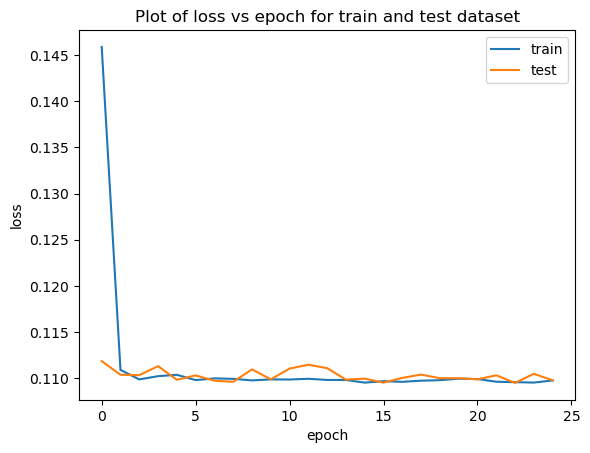

In [29]:
# Plot of loss vs epoch for train and test dataset
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()